## Package Installation

In [3]:
# install ase and amp
!pip3 install amp-atomistics
!pip install ase
# Install Nwchem
# !sudo apt update
# !sudo apt -y install mpi-default-bin libgfortran4 libopenblas-base \
# libopenmpi2 libscalapack-openmpi2.0 openmpi-bin libquadmath0 \
# libfabric1 libhwloc5 libibverbs1 libpsm-infinipath1 \
# openmpi-common libhwloc-plugins libnl-route-3-200 \
# ocl-icd-libopencl1  librdmacm1
# !wget https://github.com/nwchemgit/nwchem/releases/download/6.8.1-release/nwchem-data_6.8.1+133+gitge032219-2_all.ubuntu_bionic.deb
# !wget https://github.com/nwchemgit/nwchem/releases/download/6.8.1-release/nwchem_6.8.1+133+gitge032219-2_amd64.ubuntu_bionic.deb
# !sudo dpkg -i nwchem_6.8.1+133+gitge032219-2_amd64.ubuntu_bionic.deb nwchem-data_6.8.1+133+gitge032219-2_all.ubuntu_bionic.deb

     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 2.0MB 43.6MB/s 
  Created wheel for amp-atomistics: filename=amp_atomistics-0.6.1-cp36-cp36m-linux_x86_64.whl size=396519 sha256=7b27ea475f2a1419acb986c3efa8679be63f9bc3274993163366002e537f0d15
  Stored in directory: /root/.cache/pip/wheels/47/d6/45/58abd238ea8c11658b0a5ab89b2921baee491e049a7c204b21
Successfully built amp-atomistics


## Import necessary packages and functions

In [0]:
from __future__ import print_function

from ase.cluster.cubic import FaceCenteredCubic
from ase.optimize import QuasiNewton
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.build import molecule
from ase.calculators.nwchem import NWChem

from ase.io import read, Trajectory
from amp import Amp

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### NWChem DFT MD calculation

In [0]:
%%time
# Set up a atom project
pos = [1.1*0.969, 1.*0.969] #[r1, r2, theta]

atoms = molecule('H2O')
atoms.cell = np.array(np.diag([15, 15.1, 15.2]))
# water.set_angle(1, 0, 2, pos[2])
atoms.set_distance(0, 1, pos[0], fix=0)
atoms.set_distance(0, 2, pos[1], fix=0)
atoms.center()
print(atoms.get_positions())

# atoms.set_calculator(EMT())
calc = NWChem(label='calc/nwchem', maxiter=2000, xc='B3LYP', basis='6-31+G**')
atoms.set_calculator(calc)
atoms.get_potential_energy()
atoms.get_kinetic_energy()

%rm -rf dft.traj
traj = Trajectory('dft.traj', 'w')
traj.write(atoms)

# Do a quick relaxation of the cluster
# qn = QuasiNewton(atoms)
# qn.run(0.001, 10)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, 300* units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

# We want to run MD using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1.5 * units.fs)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    traj.write(a)

dyn.attach(printenergy, interval=10)

# Now run the dynamics
printenergy()
dyn.run(1000)

[[7.5        7.51182091 7.92811724]
 [7.5        8.35176086 7.27188276]
 [7.5        6.74823914 7.33154044]]
Energy per atom: Epot = -693.222eV  Ekin = 0.049eV (T=381K)  Etot = -693.173eV
Energy per atom: Epot = -693.222eV  Ekin = 0.049eV (T=381K)  Etot = -693.173eV
Energy per atom: Epot = -693.217eV  Ekin = 0.047eV (T=367K)  Etot = -693.170eV
Energy per atom: Epot = -693.243eV  Ekin = 0.064eV (T=494K)  Etot = -693.179eV
Energy per atom: Epot = -693.215eV  Ekin = 0.041eV (T=314K)  Etot = -693.174eV
Energy per atom: Epot = -693.185eV  Ekin = 0.022eV (T=171K)  Etot = -693.163eV
Energy per atom: Epot = -693.285eV  Ekin = 0.096eV (T=740K)  Etot = -693.189eV
Energy per atom: Epot = -693.153eV  Ekin = 0.005eV (T= 40K)  Etot = -693.148eV
Energy per atom: Epot = -693.281eV  Ekin = 0.089eV (T=687K)  Etot = -693.192eV
Energy per atom: Epot = -693.189eV  Ekin = 0.022eV (T=171K)  Etot = -693.167eV
Energy per atom: Epot = -693.238eV  Ekin = 0.059eV (T=455K)  Etot = -693.179eV
Energy per atom: Epot 

### AMP MD Calculation

In [0]:
from google.colab import files
files.upload()

Saving amp.amp to amp.amp


{'amp.amp': b'dict(descriptor="dict(Gs={\'H\': [{\'type\': \'G2\', \'element\': \'H\', \'eta\': 0.049999999999999996}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 0.049999999999999996}, {\'type\': \'G2\', \'element\': \'H\', \'eta\': 0.2320794416806389}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 0.2320794416806389}, {\'type\': \'G2\', \'element\': \'H\', \'eta\': 1.0772173450159415}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 1.0772173450159415}, {\'type\': \'G2\', \'element\': \'H\', \'eta\': 5.000000000000001}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 5.000000000000001}, {\'type\': \'G4\', \'elements\': [\'H\', \'H\'], \'eta\': 0.005, \'gamma\': 1.0, \'zeta\': 1.0}, {\'type\': \'G4\', \'elements\': [\'H\', \'O\'], \'eta\': 0.005, \'gamma\': 1.0, \'zeta\': 1.0}, {\'type\': \'G4\', \'elements\': [\'O\', \'O\'], \'eta\': 0.005, \'gamma\': 1.0, \'zeta\': 1.0}, {\'type\': \'G4\', \'elements\': [\'H\', \'H\'], \'eta\': 0.005, \'gamma\': -1.0, \'zeta\': 1.0}, {\'type\'

In [5]:
%%time
# !rm -rf amp-* amp.traj nwchem.traj
!ls

amp_md_noqn.traj  dft_md_noqn.traj  sample_data
CPU times: user 23.8 ms, sys: 9.55 ms, total: 33.4 ms
Wall time: 3.23 s


In [0]:
%%time

# Set up a atom project
pos = [1.1*0.969, 1.*0.969] #[r1, r2, theta]

atoms = molecule('H2O')
atoms.cell = np.array(np.diag([15, 15.1, 15.2]))
# water.set_angle(1, 0, 2, pos[2])
atoms.set_distance(0, 1, pos[0], fix=0)
atoms.set_distance(0, 2, pos[1], fix=0)
atoms.center()

print(atoms.get_positions())

calc = Amp.load('amp.amp')
atoms.set_calculator(calc)
atoms.get_potential_energy()
atoms.get_kinetic_energy()

%rm -rf amp_md.traj
traj = Trajectory('amp_md.traj', 'w')
traj.write(atoms)

# qn = QuasiNewton(atoms)
# qn.run(0.001, 10)

MaxwellBoltzmannDistribution(atoms, 300.* units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

dyn = VelocityVerlet(atoms, 1.5 * units.fs)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    traj.write(a)
dyn.attach(printenergy, interval=10)

#Now run the dynamics
printenergy()

dyn.run(1000)

[[7.5        7.51182091 7.92811724]
 [7.5        8.35176086 7.27188276]
 [7.5        6.74823914 7.33154044]]
Energy per atom: Epot = -693.125eV  Ekin = 0.058eV (T=448K)  Etot = -693.067eV
Energy per atom: Epot = -693.125eV  Ekin = 0.058eV (T=448K)  Etot = -693.067eV
Energy per atom: Epot = -693.070eV  Ekin = 0.020eV (T=154K)  Etot = -693.050eV
Energy per atom: Epot = -693.175eV  Ekin = 0.086eV (T=664K)  Etot = -693.089eV
Energy per atom: Epot = -693.101eV  Ekin = 0.035eV (T=270K)  Etot = -693.066eV
Energy per atom: Epot = -693.125eV  Ekin = 0.055eV (T=422K)  Etot = -693.070eV
Energy per atom: Epot = -693.109eV  Ekin = 0.042eV (T=329K)  Etot = -693.067eV
Energy per atom: Epot = -693.112eV  Ekin = 0.055eV (T=427K)  Etot = -693.057eV
Energy per atom: Epot = -693.154eV  Ekin = 0.072eV (T=555K)  Etot = -693.082eV
Energy per atom: Epot = -693.084eV  Ekin = 0.028eV (T=220K)  Etot = -693.055eV
Energy per atom: Epot = -693.130eV  Ekin = 0.054eV (T=421K)  Etot = -693.075eV
Energy per atom: Epot 

## Result Analysis

In [2]:
from google.colab import files
files.upload()

Saving amp_md_noqn.traj to amp_md_noqn.traj


{'amp_md_noqn.traj': b'- of UlmASE-Trajectory  \x03\x00\x00\x00\x00\x00\x00\x00\xeb\x03\x00\x00\x00\x00\x00\x00\x98Y\x00\x00\x00\x00\x00\x00\x98\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e@333333\x1e@[\x051\xd0\xb5\x97\x1f@\x00\x00\x00\x00\x00\x00\x1e@\xda\xa9\xb9\xdc`\xa0 @q\xc7\x9b\xfc\x165\x1d@\x00\x00\x00\x00\x00\x00\x1e@\xb2\x12\xf3\xac\xa4%\x1b@q\xc7\x9b\xfc\x165\x1d@6\x01\x00\x00\x00\x00\x00\x00{"version": 1, "ase_version": "3.18.0", "pbc": [false, false, false], "numbers.": {"ndarray": [[3], "int64", 56]}, "positions.": {"ndarray": [[3, 3], "float64", 80]}, "cell": [[15.0, 0.0, 0.0], [0.0, 15.1, 0.0], [0.0, 0.0, 15.2]], "calculator.": {"name": "amp", "parameters": {}, "energy": -2079.558377877068}}##\x00\x00\x00\x00\x00\x00\x1e@333333\x1e@[\x051\xd0\xb5\x97\x1f@\x00\x00\x00\x00\x00\x00\x1e@\xda\xa9\xb9\xdc`\xa0 @q\xc7\x9b\xfc\x165\x1d@\x00\x00\x00\x00\x00\x00\x1e@\xb2\x12

In [41]:
amp_file = 'amp_md_noqn.traj'
dft_file = 'dft_md_noqn.traj'

amp_md = read(amp_file, index=':')
amp_positions = []
amp_potential, amp_kinetic = [], []
amp_angles, amp_r = [], []
for i in range(len(amp_md)):
    amp_positions.append(amp_md[i].get_positions())
    amp_potential.append(amp_md[i].get_potential_energy())
    amp_kinetic.append(amp_md[i].get_kinetic_energy())
    amp_angles.append(amp_md[i].get_angle(1,0,2))
    amp_r.append(amp_md[i].get_distances(0,[1,2]))
amp_positions = np.array(amp_positions)
amp_potential = np.array(amp_potential)
amp_kinetic = np.array(amp_kinetic)
print(amp_positions.shape)

dft_md = read(dft_file, index=':')
dft_positions = []
dft_potential, dft_kinetic = [], []
dft_angles, dft_r = [], []
for i in range(len(dft_md)):
    dft_positions.append(dft_md[i].get_positions())
    dft_potential.append(dft_md[i].get_potential_energy())
    dft_kinetic.append(dft_md[i].get_kinetic_energy())
    dft_angles.append(dft_md[i].get_angle(1,0,2))
    dft_r.append(dft_md[i].get_distances(0,[1,2]))
dft_positions = np.array(dft_positions)
dft_potential = np.array(dft_potential)
dft_kinetic = np.array(dft_kinetic)
print(dft_positions.shape)
rmse = np.sqrt(np.mean(np.absolute(amp_positions - dft_positions)**2))
print(rmse)

(1003, 3, 3)
(1003, 3, 3)
0.04438210803853363


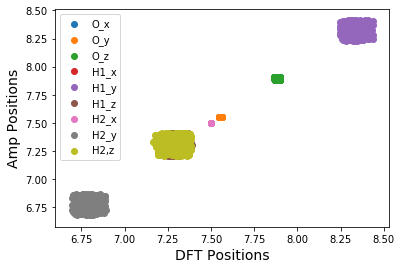

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
labels = np.array([['O_x', 'O_y', 'O_z'], ['H1_x', 'H1_y', 'H1_z'], ['H2_x', 'H2_y', 'H2,z']])
for i in range(3):
    for j in range(3):
      plt.scatter(dft_positions[:,i,j], amp_positions[:,i,j], label=labels[i,j])
plt.xlabel('DFT Positions', fontsize=14)
plt.ylabel('Amp Positions', fontsize=14)
plt.legend()
plt.show()

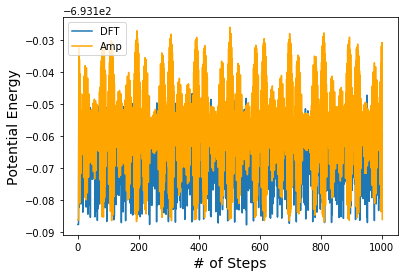

In [8]:
plt.figure()
plt.plot(np.arange(len(dft_potential)), dft_potential/3, label='DFT')
plt.plot(np.arange(len(amp_potential)), amp_potential/3, c='orange', label='Amp')
plt.xlabel('# of Steps', fontsize=14)
plt.ylabel('Potential Energy', fontsize=14)
plt.legend()
plt.show()

### Calculate Correlation Function


Data shape: 
 - amp: [103.99987509868836, 103.99987509868836, 103.99987509868836, 93.11611275026138, 107.73533781364613, 117.91856088809409, 102.19486914689683, 93.82738030228236, 109.9348730724992, 117.57974609466095, 100.47778328482443, 94.94092155202188, 112.24896113395326, 117.03477380545628, 98.93812905999506, 96.31865885668309, 114.39013357342246, 116.17762216594336, 97.61026178356127, 97.90595821536775, 116.14799458178827, 114.89325634091155, 96.43007448754884, 99.7044257469231, 117.5320863577762, 113.24135042605761, 95.34738810516173, 101.58706375570526, 118.55003820926663, 111.33654481850748, 94.44190343783971, 103.39425212503942, 119.08537866529282, 109.1800615591176, 93.79005955864294, 105.1350987311331, 119.10730293764107, 106.80569944401635, 93.4037280870096, 106.88307821270081, 118.73478892928141, 104.41160402326643, 93.34243195817757, 108.61278885178366, 118.02813544589024, 102.18047740290365, 93.67421646998697, 110.22703179290957, 117.0082579299439, 100.14483515997203, 

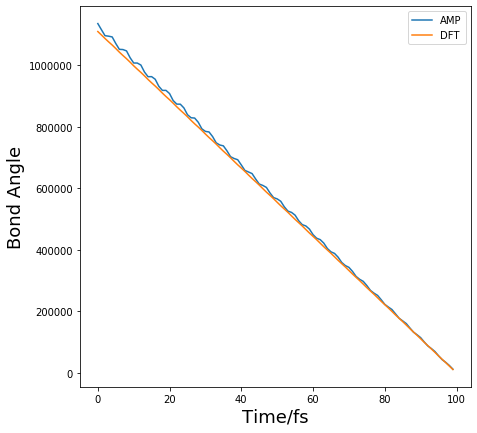

In [82]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

print("Data shape: \n - amp: {} \n - dft: {}".format(amp_angles, dft_angles))

def autocorr(x):
  result = np.correlate(x, x, mode='full')
  return result[result.size // 2:]

amp_cor = autocorr(amp_angles[:100])
dft_cor = autocorr(dft_angles[:100])
# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,7))
# ax.plot(np.arange(len(amp_positions)), amp_positions[:,0,1])
ax.plot(amp_cor, label='AMP')
ax.plot(dft_cor, label='DFT')
ax.set_xlabel('Time/fs', fontsize=18)
ax.set_ylabel('Bond Angle', fontsize=18)
ax.legend()
# ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

In [84]:
print(np.correlate(amp_angles[:50], amp_angles[:50], mode='full'))
print(np.correlate(dft_angles[:50], dft_angles[:50]))

[ 10415.05034842  22583.89455865  34047.49209761  42699.64632415
  53516.9530236   67322.54680284  78827.04382768  87236.68539692
  98159.43488235 112346.80504465 123803.30547538 131936.65014572
 143096.05116831 157716.88640045 169024.36238075 176847.99246253
 188354.60824008 203415.56241822 214455.50672698 221956.05185004
 233897.51132178 249344.31332443 259967.8350264  267169.59400424
 279643.84132709 295391.27123993 305432.94205338 312379.03471887
 325490.10371247 341438.13610034 350756.32915664 357503.26805993
 371325.65782841 387335.1511393  395820.8683574  402469.9680502
 417052.99122258 432947.53491248 440512.72353483 447218.67759424
 462613.69375183 478222.26235666 484816.16349264 491761.46170408
 508007.87702553 523179.29010752 528806.70322083 536179.25248552
 551818.07929153 566214.47935326 551818.07929153 536179.25248552
 528806.70322083 523179.29010752 508007.87702553 491761.46170408
 484816.16349264 478222.26235666 462613.69375183 447218.67759424
 440512.72353483 432947.53